In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa.stattools import adfuller

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
spy_data = pd.read_csv('/content/drive/My Drive/Maroon Capital/SPY.csv')
ishare_data = pd.read_csv('/content/drive/My Drive/Maroon Capital/GOVT.csv')

In [ ]:
spy_data_close = spy_data[['Date', 'Close']].copy()
ishare_data_close = ishare_data[['Date', 'Close']].copy()

In [ ]:
spy_data_close = spy_data_close.iloc[1:, :]

In [ ]:
all_data = pd.merge(spy_data_close, ishare_data_close, on='Date')
all_data['Date'] = pd.to_datetime(all_data['Date'])
all_data.set_index('Date', inplace = True)

In [ ]:
all_data.rename(columns = {'Close_x': 'SPY', 'Close_y': 'GOVT'}, inplace = True)
all_data

,SPY,GOVT
Date,,
2012-02-24,136.929993,24.820000
2012-02-27,137.160004,24.820000
2012-02-28,137.559998,24.820000
2012-02-29,137.020004,24.820000
2012-03-01,137.729996,24.820000
...,...,...
2023-02-13,412.829987,23.000000
2023-02-14,412.640015,22.930000
2023-02-15,413.980011,22.870001


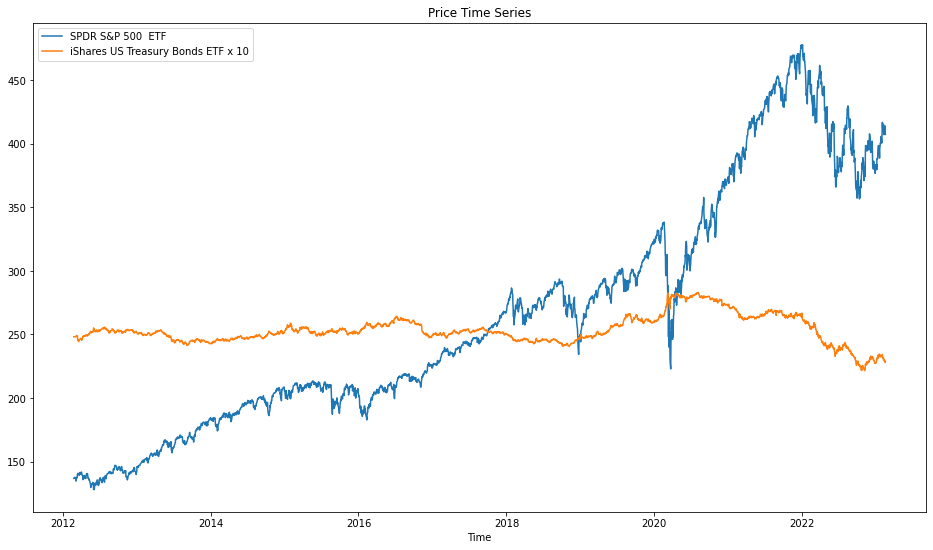

In [ ]:
plt.figure(figsize=(10, ))
plt.plot(all_data.SPY, label="SPDR S&P 500  ETF")
plt.plot(all_data.GOVT * 10, label= 'iShares US Treasury Bonds ETF x 10')
plt.xlabel("Time")
plt.legend(loc="upper left")
plt.title("Price Time Series")
plt.show()

Text(0.5, 1.0, 'iShares US Treasury Bonds ETF')

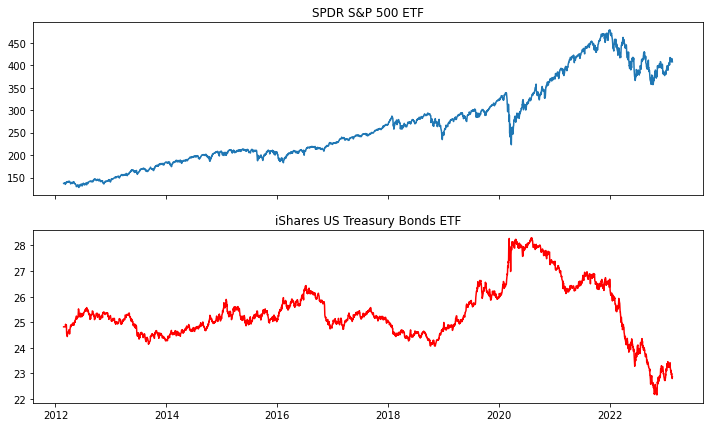

In [ ]:
fig, axs = plt.subplots(2, sharex = True, sharey = False, figsize = (12, 7))

axs[0].plot(all_data.SPY)
axs[0].set_title('SPDR S&P 500 ETF')
axs[1].plot(all_data.GOVT, c = 'red')
axs[1].set_title('iShares US Treasury Bonds ETF')

In [ ]:
# Function to execute strategy

def run_strategy_spygovt(data, lookback, width, hr_lookback_months):
  monthly_trading_days = 21
  hr_lookback = monthly_trading_days * hr_lookback_months

  #Hedge Ratio and Spread Calculations
  df = data.copy()
  df['hedge_ratio'] = df['SPY'].rolling(hr_lookback).corr(df['GOVT']) * df['SPY'].rolling(hr_lookback).std() / df['GOVT'].rolling(hr_lookback).std()
  df['spread'] = df['SPY'] - df['hedge_ratio'] * df['GOVT']

  #BB calculations
  df['rolling_spread'] = df['spread'].rolling(lookback).mean() #lookback-day SMA of spread
  df['rolling_spread_std'] = df['spread'].rolling(lookback).std() #lookback-day rolling STD of spread
  df['upper_band'] = df['rolling_spread'] + (width * df['rolling_spread_std']) #upper = SMA + width * STD
  df['lower_band'] = df['rolling_spread'] - (width * df['rolling_spread_std']) #lower = SMA - width * STD']

  #SPY position calculation
  df['Position SPY'] = np.nan
  for date in df.index:
    if df.loc[date, 'spread'] > df.loc[date, 'upper_band']:
        df.loc[date, 'Position SPY'] = -1
    elif df.loc[date, 'spread'] < df.loc[date, 'lower_band']:
        df.loc[date, 'Position SPY'] = 1
    elif (df.loc[date, 'spread'] >= df.loc[date, 'lower_band']) & (df.loc[date, 'spread'] <= df.loc[date, 'upper_band']):
        df.loc[date, 'Position SPY'] = 0

  df['Position GOVT'] = - df['hedge_ratio'] * df['Position SPY']

  df['P&L Bonds'] = df['Position GOVT'] * df['GOVT'].diff().shift(-1)
  df['P&L SP500'] = df['Position SPY'] * df['SPY'].diff().shift(-1)

  df['P&L'] = df['P&L Bonds'] + df['P&L SP500']

  return df

In [ ]:
# Getting a 70-30 training split for the data

cutoff = round(0.7*len(all_data.index))
train = all_data.iloc[:cutoff]
test = all_data.iloc[cutoff:]

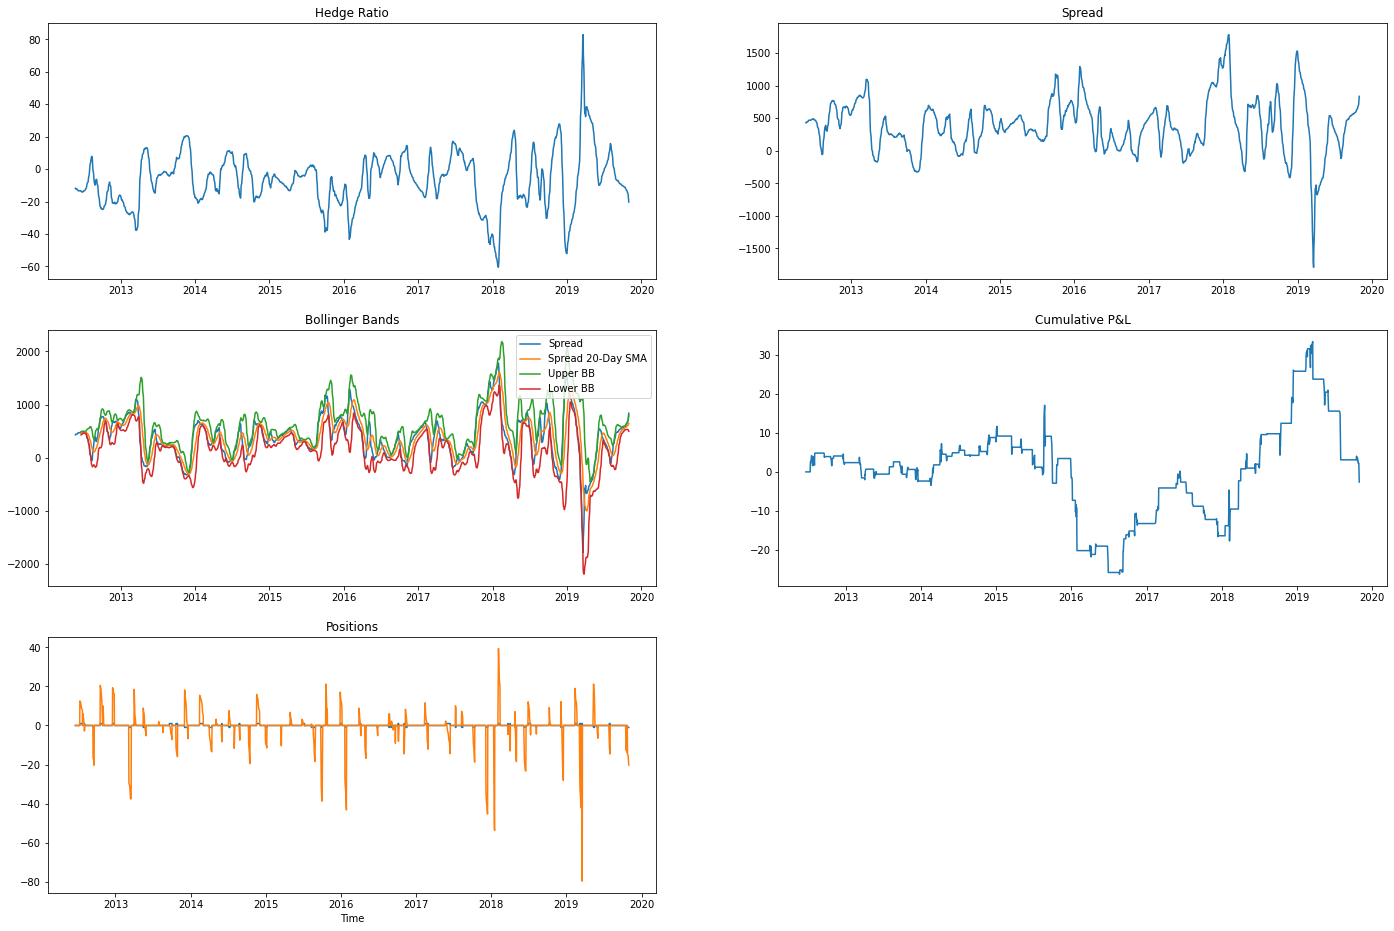

In [ ]:
df = run_strategy_spygovt(train, 20, 2, 3) #20-day and 2 STD are the standard BB parameters used

#plot intermediate and final results of using these parameters on training data
fig = plt.figure(figsize=(24,16)) #overall plot size
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)

ax1.plot(df['hedge_ratio'])
ax1.set_title("Hedge Ratio")

ax2.plot(df['spread'])
ax2.set_title("Spread")

ax3.plot(df['spread'], label = 'Spread')
ax3.plot(df['rolling_spread'], label = 'Spread 20-Day SMA')
ax3.plot(df['upper_band'], label = 'Upper BB')
ax3.plot(df['lower_band'], label = 'Lower BB')
ax3.set_title("Bollinger Bands")
ax3.legend(loc="upper right")

ax4.plot(df['P&L'].cumsum())
ax4.set_title("Cumulative P&L")

ax5.plot(df['Position SPY'], label = "SPY")
ax5.plot(df['Position GOVT'], label = "GOVT")
ax5.set_title("Positions")

plt.xlabel("Time")
plt.show()

In [ ]:
# Function to check for stationarity using the Dickey-Fuller Test

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [ ]:
test_df = run_strategy_spygovt(train, 20, 2, 3)

In [ ]:
# Plotting cumulative P&L and spread, redundant with plots above

plt.figure(figsize=(10, 5))
plt.plot(test_df['P&L'].cumsum())
plt.title('PnL Graph: Training Set with parameters (20, 2, 3)')
plt.xlabel('Time')
plt.ylabel('Profits & Losses')

plt.show()
plt.figure(figsize=(8, 5))
plt.plot(test_df['spread'])
plt.title('Training set spread - parameters (20, 2, 3)')
plt.xlabel('Time')
plt.ylabel('Spread')

plt.show()

In [ ]:
print('mean pnl:', test_df['P&L'].mean())
print('std pnl:', test_df['P&L'].std())

mean pnl: -0.0014022103143192313
std pnl: 0.9314262230484942


In [ ]:
# Function to calculate Sharpe Ratio

def get_sharpe(r, rfr=0.02):
  if r.std():
    return (r.mean() - rfr) / r.std() * np.sqrt(252)
  return 0

In [ ]:
print('Sharpe ratio:', get_sharpe(test_df['P&L']))

Sharpe ratio: -0.3647627129079148


In [ ]:
# Performing grid-search to identify optimal parameters for the algorithm

lookback = np.linspace(start=1, stop=9, num=9) * 21
multipliers = np.linspace(start=0.2, stop=3, num=15)
months = [1, 2, 3]

print('lookback windows:', list(lookback))
print('multipliers:', list(multipliers))
print('months:', months)

lookback windows: [21.0, 42.0, 63.0, 84.0, 105.0, 126.0, 147.0, 168.0, 189.0]
multipliers: [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.5999999999999999, 1.7999999999999998, 1.9999999999999998, 2.1999999999999997, 2.4, 2.6, 2.8, 3.0]
months: [1, 2, 3]


In [ ]:
# Code for grid-search

%%time

train_sharpes = []
for l in lookback:
  for m in multipliers:
    for c in months:
      df = run_strategy_spygovt(train, int(l), m, c)
      train_sharpes.append({
          'lookback window': l,
          'multiplier': m,
          'months': c,
          'sharpe': get_sharpe(df['P&L'])
      })



CPU times: user 6min 9s, sys: 3.03 s, total: 6min 12s
Wall time: 6min 13s


In [ ]:
max(train_sharpes, key=lambda r: r['sharpe'])

{'lookback window': 105.0,
 'multiplier': 2.4,
 'months': 1,
 'sharpe': 0.308171430652217}

In [ ]:
optimal_df = run_strategy_spygovt(train, 105, 2.4, 1)

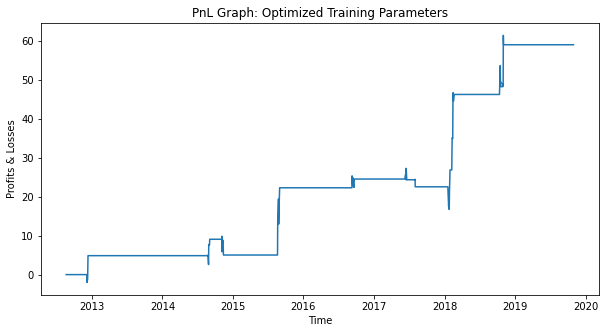

In [ ]:
# PnL for the optimized Sharpe Ratio

plt.figure(figsize=(10, 5))
plt.plot(optimal_df['P&L'].cumsum())
plt.title('PnL Graph: Optimized Training Parameters')
plt.xlabel('Time')
plt.ylabel('Profits & Losses')

plt.show()

In [ ]:
adf_test(optimal_df['spread'][1*21:])

Results of Dickey-Fuller Test:
Test Statistic                -7.198333e+00
p-value                        2.401786e-10
#Lags Used                     1.600000e+01
Number of Observations Used    1.897000e+03
Critical Value (1%)           -3.433802e+00
Critical Value (5%)           -2.863065e+00
Critical Value (10%)          -2.567582e+00
dtype: float64


In [ ]:
# Running strategy on the test set

optimal_df_test = run_strategy_spygovt(test, 105, 2.4, 1)

print('Test Sharpe Ratio:', get_sharpe(optimal_df_test['P&L']))


Test Sharpe Ratio: -0.5807577582263164


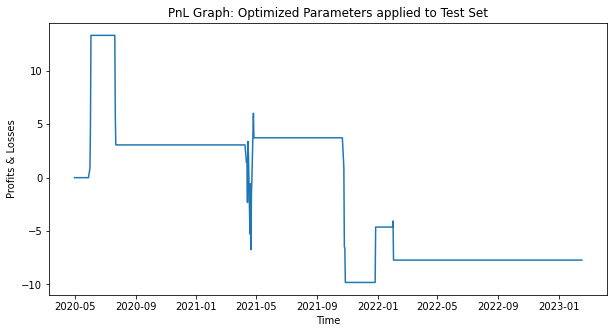

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(optimal_df_test['P&L'].cumsum())
plt.title('PnL Graph: Optimized Parameters applied to Test Set')
plt.xlabel('Time')
plt.ylabel('Profits & Losses')

plt.show()

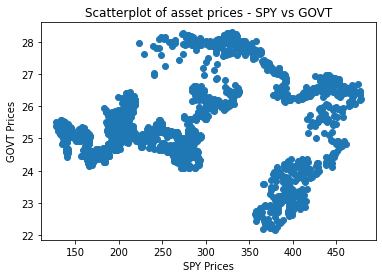

In [ ]:
plt.scatter(all_data.SPY, all_data.GOVT)

plt.xlabel('SPY Prices')
plt.ylabel('GOVT Prices')
plt.title('Scatterplot of asset prices - SPY vs GOVT')
plt.show()

Text(0.5, 1.0, 'Hedge Ratio vs Time for Optimal Strategy Parameters')

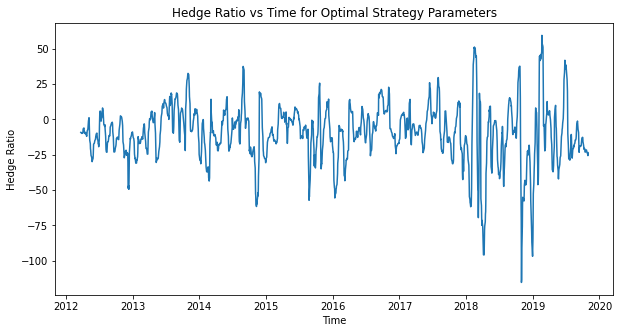

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(optimal_df['hedge_ratio'])
plt.xlabel('Time')
plt.ylabel('Hedge Ratio')
plt.title('Hedge Ratio vs Time for Optimal Strategy Parameters')
#plt.hlines(0, xmin = all_data.index[0], xmax = all_data.index[-1], linestyle = 'dashed')